<a href="https://www.kaggle.com/code/adelinmil/pg-s03e23-quick-and-dirty-implementation?scriptVersionId=147509132" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install nb-black==1.0.5 --quiet

%load_ext lab_black

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np

SEED = 42

# ploting
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 6)

# CV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

# metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

# Hyperparameters Tuning
import optuna

# Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# Handle Imbalance
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings

warnings.filterwarnings("ignore")

# <center> [PG S03E23 | EDA](https://www.kaggle.com/code/adelinmil/pg-s03e23-eda)

In [3]:
tr = pd.read_csv(
    "/kaggle/input/playground-series-s3e23/train.csv",
    usecols=lambda x: x != "id",
    dtype={"defects": int},
)
ts = pd.read_csv("/kaggle/input/playground-series-s3e23/test.csv")

test_ids = ts.pop("id")

In [4]:
x, y = tr.drop("defects", axis=1), tr["defects"]

In [5]:
tmp_estimators = [
    ("lgbm", LGBMClassifier(random_state=SEED, n_jobs=-1)),
    ("cat", CatBoostClassifier(random_state=SEED, verbose=False)),
    ("hist", HistGradientBoostingClassifier(random_state=SEED)),
    ("xgb", XGBClassifier(random_state=SEED, n_jobs=-1)),
    ("etc", ExtraTreesClassifier(random_state=SEED, n_jobs=-1)),
    ("rf", RandomForestClassifier(random_state=SEED, n_jobs=-1)),
    ("lr", LogisticRegression(random_state=SEED, max_iter=5000, n_jobs=-1)),
]

In [6]:
def experiment(x, y, COMMENT):
    xtr, xts, ytr, yts = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=SEED
    )
    results, names = list(), list()

    estimators = [
        ("lgbm", LGBMClassifier(random_state=SEED, n_jobs=-1)),
        ("cat", CatBoostClassifier(random_state=SEED, verbose=False)),
        ("hist", HistGradientBoostingClassifier(random_state=SEED)),
        ("xgb", XGBClassifier(random_state=SEED, n_jobs=-1)),
        ("etc", ExtraTreesClassifier(random_state=SEED, n_jobs=-1)),
        ("rf", RandomForestClassifier(random_state=SEED, n_jobs=-1)),
        ("lr", LogisticRegression(random_state=SEED, max_iter=5000, n_jobs=-1)),
        (
            "eclf",
            VotingClassifier(
                estimators=tmp_estimators,
                voting="soft",
                weights=results,
            ),
        ),
    ]

    for name, clf in estimators:
        clf.fit(xtr, ytr)
        result = roc_auc_score(yts, clf.predict_proba(xts)[:, 1])
        results.append(result)
        names.append(clf.__class__.__name__)

    #     print("\tComment: " + COMMENT + "\n\n")
    scores = pd.Series(results, name="roc_auc_score", index=names).sort_values()

    with plt.style.context("dark_background"):
        ax = sns.barplot(x=scores.values, y=scores.index)
        ax.set_title(COMMENT, fontsize=18)
        ax.bar_label(ax.containers[0], fontsize=12)
        plt.show()
    return results[:-1]

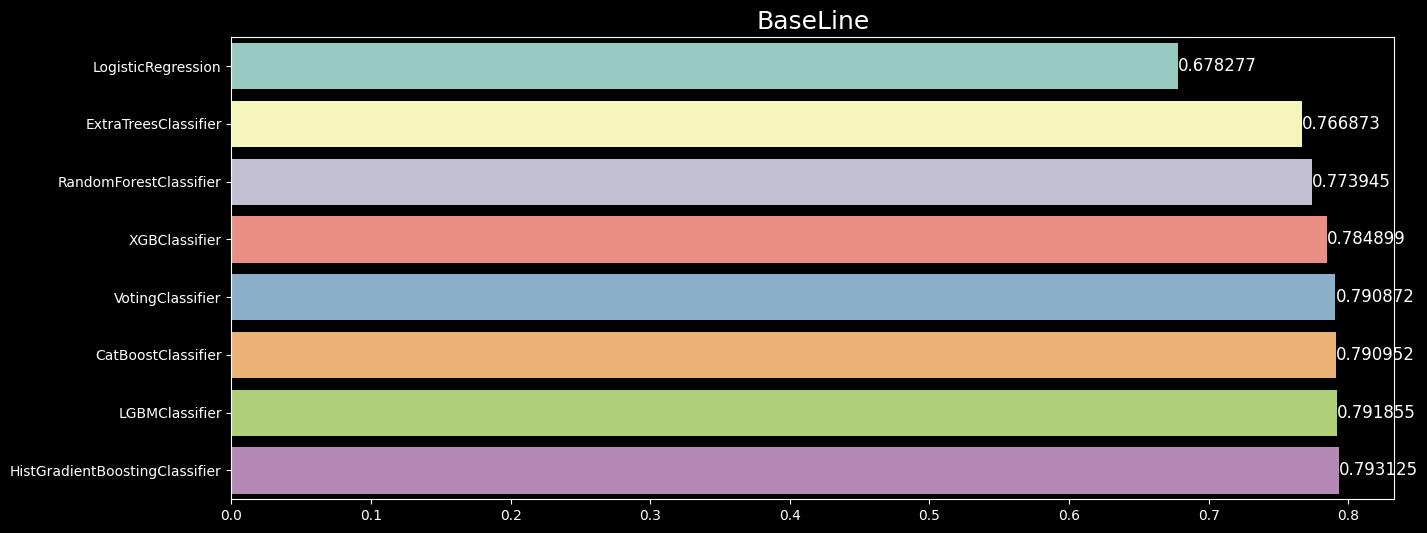

In [7]:
results = experiment(x, y, "BaseLine")

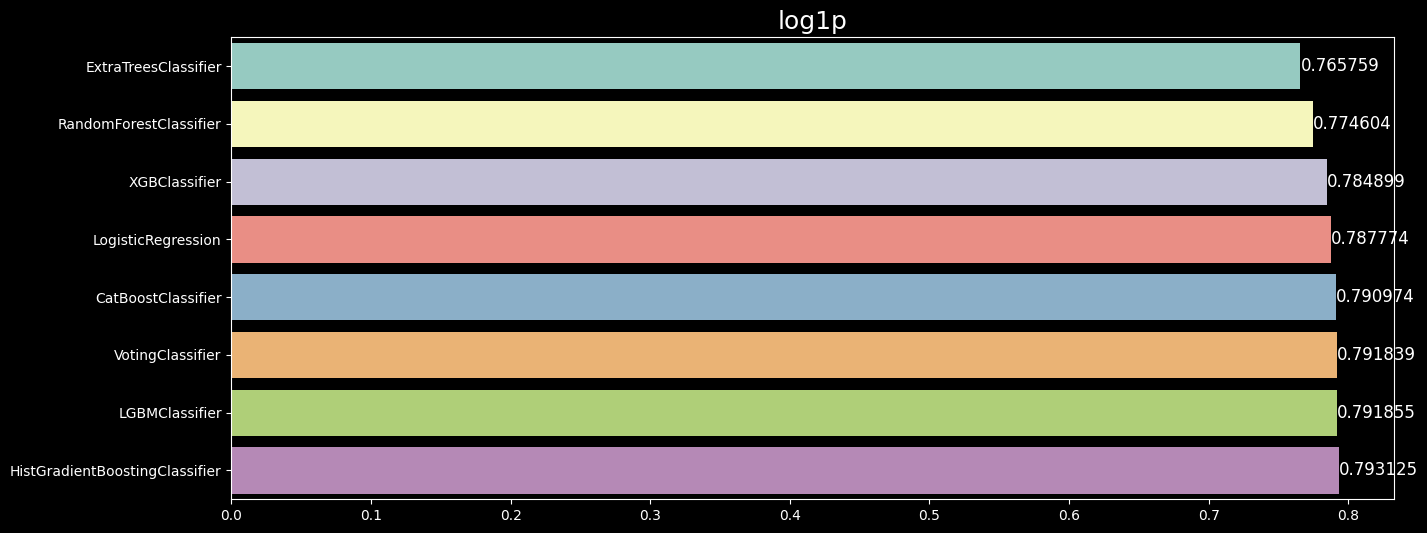

In [8]:
df = pd.concat([x.copy(), ts], axis = 0).reset_index(drop = True)
for column in df.columns:
    df[column] = df[column].apply(lambda x: np.log1p(x))

x_new = df.iloc[:len(x)]
ts = df.iloc[len(x):]

results = experiment(x_new, y, "log1p")

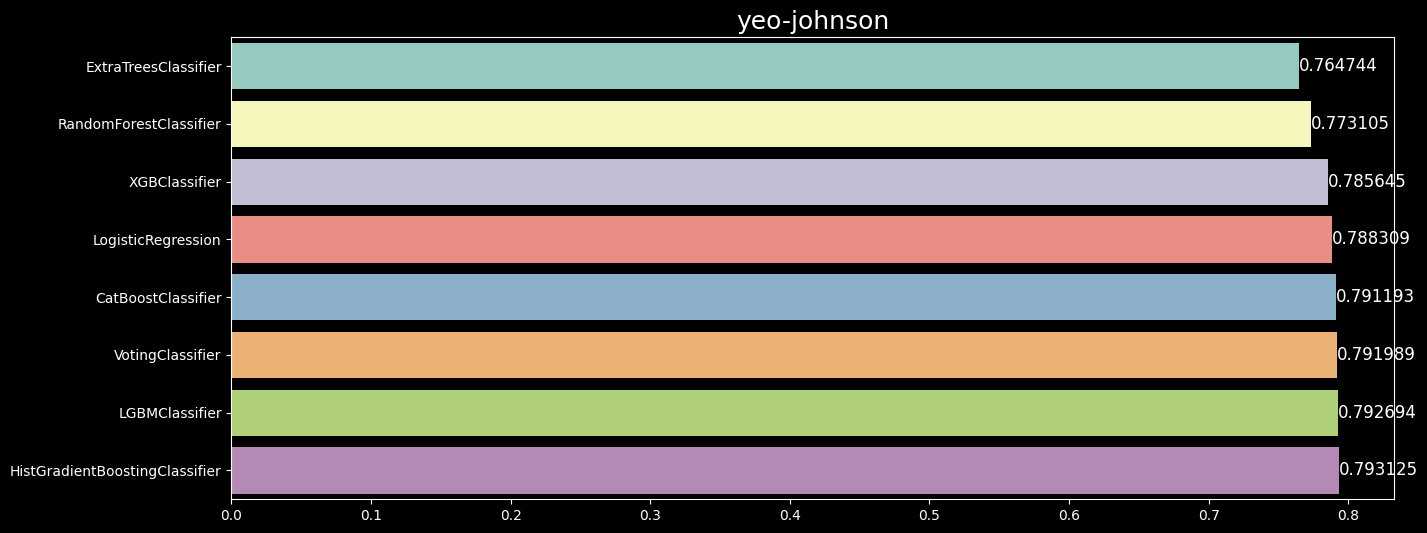

In [9]:
pt = PowerTransformer()

df = pd.concat([x.copy(), ts], axis = 0).reset_index(drop = True)
df = pd.DataFrame(pt.fit_transform(df), columns=df.columns)

x_new = df.iloc[:len(x)]
ts = df.iloc[len(x):]

results = experiment(x_new, y, "yeo-johnson")

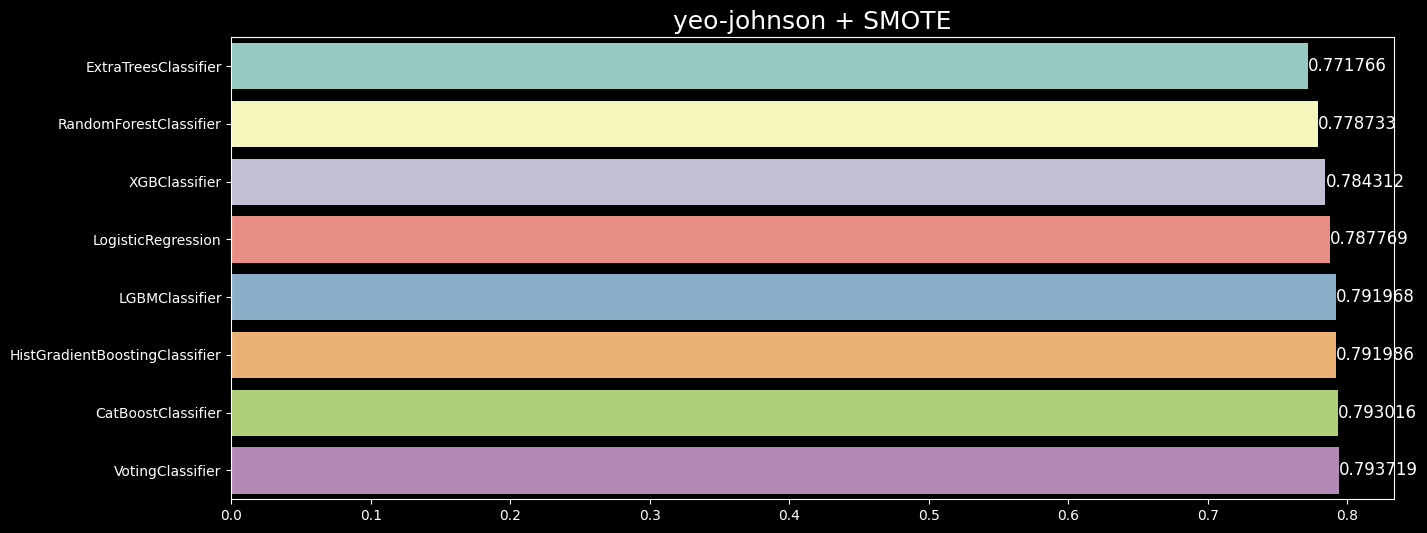

In [10]:
over = SMOTE(sampling_strategy=0.3, random_state=SEED)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=SEED)
steps = [("o", over), ("u", under)]
pipeline = Pipeline(steps=steps)

os_x, os_y = pipeline.fit_resample(x_new, y)

results = experiment(os_x, os_y, "yeo-johnson + SMOTE")

In [11]:
eclf = VotingClassifier(
    estimators=tmp_estimators,
    voting="soft",
    weights=results,
)

kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
scores = cross_val_score(eclf, os_x, os_y, scoring="roc_auc", cv=kf, n_jobs=-1)
print(f"{eclf.__class__.__name__} auroc score: {scores.mean()}")

VotingClassifier auroc score: 0.7936516646009861


In [12]:
eclf.fit(os_x, os_y)
submission = pd.DataFrame(
    {"id": test_ids, "defects": pd.Series(eclf.predict_proba(ts)[:, 1])}
)
submission.head()

,id,defects
0,101763,0.233863
1,101764,0.188275
2,101765,0.257131
3,101766,0.307012
4,101767,0.227875


In [13]:
submission.to_csv("submission.csv", index=False)

# <center> <span style="color:orange"> If You Find This Notebook Helpful Please Consider Upvoting and Sharing.